In [39]:
#librerias
import pandas as pd
from dateutil.easter import easter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Time**

In [40]:
df_time = pd.read_csv("../data/raw/time.csv")
df_time = df_time.sort_index()
df_time.head()

,ID_Date,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek
0,202201,31,5,7,21,10,0
1,202202,28,1,7,20,8,0
2,202203,31,1,3,23,8,0
3,202204,30,4,5,22,8,1
4,202205,31,6,1,21,10,0


**Web**

In [41]:
df_web=pd.read_csv('../data/raw/web.csv')
df_web['ID_Date'] = pd.to_datetime(df_web['ID_Date'], format='%Y%m')
df_web.set_index('ID_Date', inplace=True)
df_web.head()

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
ID_Date,,,,,,,,,,,
2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656
2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,15243
2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,18510
2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,20031


**Offline**

In [70]:
path='../data/raw/offline.csv'
df_off=pd.read_csv(path)
df_off['ID_Date'] = pd.to_datetime(df_off['ID_Date'], format='%Y%m')
df_off.set_index('ID_Date', inplace=True)
df_off.head()

,Visit_Store,Mercado,Sales,Complementos,Ropa_hombre,Zapatos,Ropa_Mujer,Home,Interior,Otros,Ticket_medio
ID_Date,,,,,,,,,,,
2022-01-01,5516,76331,1299,115,270,273,444,131,60,6,68
2022-02-01,6769,97646,1752,155,393,286,689,179,42,8,86
2022-03-01,6249,111510,1897,148,442,333,693,249,30,2,92
2022-04-01,6507,100269,1546,110,371,297,591,154,23,0,87
2022-05-01,7183,113667,1784,138,411,374,635,187,38,1,83


**Mercado Sarima**

In [43]:
path='../data/sarima/pred_mercado_sarima.csv'
df_pred_mercado_sarima=pd.read_csv(path)
df_pred_mercado_sarima.head()

,Fecha,Mercado
0,2025-01-01,98634.000000
1,2025-02-01,102528.677793
2,2025-03-01,117652.495742
3,2025-04-01,113512.663871
4,2025-05-01,125159.943305


# Carga y Selección Datos

**Estrategia para preparar las variables del modelo de atribución (2025-2026)**

Para realizar las simulaciones del modelo de atribución en 2025 y 2026, se aplicarán diferentes enfoques según la naturaleza de cada variable:

1. `Mercado`
- **Método**: Proyección con modelo SARIMA.
- **Justificación**: La serie muestra estacionalidad clara y buena capacidad de ajuste.

 2. `DirectTraffic` y `Unique_visitors`
- **Método**: Media mensual histórica.
- **Justificación**: Los modelos SARIMA no capturan bien la tendencia futura debido a la poca capacidad de generalización y al ruido en los últimos datos. La media mensual por mes (ej. media de todos los eneros, febreros, etc.) proporciona valores estables.


 3. Variables de calendario (`working_days`, `Dias_fines_semana`, `Dia_inicio_mes`, `Easterweek`)
- **Método**: Generación automática con base en el calendario.

In [44]:
# Dataframe - índice las fechas desde 2025-01 hastas 2026-16
fechas_futuras = pd.date_range(start='2025-01-01', end='2026-12-01', freq='MS')
df_futuro = pd.DataFrame(index=fechas_futuras)

## Variables Exógenas Tiempo

In [45]:
#  Días del mes
df_futuro['Dias_mes'] = df_futuro.index.days_in_month

In [46]:
# Obtener datos de 2024 como copia segura
df_2024 = df_time[df_time['ID_Date'].astype(str).str.startswith('2024')].copy()

# Calcular días de inicio de mes +1 y +2
df_2024['Dia_inicio_mes+1'] = df_2024['Dia_inicio_mes'].apply(lambda x: 1 if x == 7 else x + 1)
df_2024['Dia_inicio_mes+2'] = df_2024['Dia_inicio_mes+1'].apply(lambda x: 1 if x == 7 else x + 1)

# Extraer listas
dias_2025 = df_2024.loc[df_2024['ID_Date'].between(202401, 202412), 'Dia_inicio_mes+1'].tolist()
dias_2026 = df_2024.loc[df_2024['ID_Date'].between(202401, 202412), 'Dia_inicio_mes+2'].tolist()

# Asegurar que hay 12 valores
assert len(dias_2025) == 12
assert len(dias_2026) == 12

# Asignar a df_futuro
df_futuro.loc['2025-01-01':'2025-12-01', 'Dia_inicio_mes'] = dias_2025
df_futuro.loc['2026-01-01':'2026-12-01', 'Dia_inicio_mes'] = dias_2026

In [47]:
# Días laborales del mes
df_futuro['working_days'] = df_futuro.index.to_series().apply(
    lambda x: pd.date_range(start=x, end=x + pd.offsets.MonthEnd(0), freq='B').size)

In [48]:
#  Días de fin de semana del mes:dias_mes-dias_trabajo
df_futuro['Dias_fines_semana'] = df_futuro['Dias_mes'] - df_futuro['working_days']

In [49]:
# Easterweek =1 si es Pascua (logrado con libreria python)
df_futuro['Easterweek'] = df_futuro.index.to_series().apply(
    lambda d: 1 if easter(d.year).month == d.month else 0
)

In [50]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek
2025-01-01,31,1.0,23,8,0
2025-02-01,28,4.0,20,8,0
2025-03-01,31,4.0,21,10,0
2025-04-01,30,7.0,22,8,1
2025-05-01,31,2.0,22,9,0


## Variables Unique Visitors y DirectTraffic

**Unique_Visitors**

In [51]:
df_web['year'] = df_web.index.year
df_web['month'] = df_web.index.month

# Predecir cada mes de 2025 usando datos reales de 2022-2024
predicciones_2025 = []
for mes in range(1, 13):
    datos_historicos = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2022, 2023, 2024]))
    ]['Unique_visitors']
    
    prediccion = datos_historicos.mean()
    predicciones_2025.append(prediccion)

fechas_2025 = pd.date_range(start="2025-01-01", end="2025-12-01", freq="MS")
df_2025 = pd.DataFrame({'Fecha': fechas_2025, 'Prediccion_Unique_visitors': predicciones_2025})

#  Predecir cada mes de 2026 usando 2023, 2024 y la predicción de 2025
predicciones_2026 = []
for mes in range(1, 13):
    datos_2023_2024 = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2023, 2024]))
    ]['Unique_visitors']
    
    pred_2025 = df_2025[df_2025['Fecha'].dt.month == mes]['Prediccion_Unique_visitors'].values[0]
    
    datos_combinados = list(datos_2023_2024) + [pred_2025]
    prediccion_2026 = sum(datos_combinados) / len(datos_combinados)
    predicciones_2026.append(prediccion_2026)

fechas_2026 = pd.date_range(start="2026-01-01", end="2026-12-01", freq="MS")
df_2026 = pd.DataFrame({'Fecha': fechas_2026, 'Prediccion_Unique_visitors': predicciones_2026})

# 5. Unir ambos años
df_pred_UV = pd.concat([df_2025, df_2026])

# Mostrar resultado
df_pred_UV.head()

,Fecha,Prediccion_Unique_visitors
0,2025-01-01,263567.000000
1,2025-02-01,304353.333333
2,2025-03-01,271983.333333
3,2025-04-01,236862.000000
4,2025-05-01,257969.000000


In [52]:
# Arreglar índice de fechas de df_pred_final
df_pred_UV.reset_index(inplace=True, drop=True)  # quitar índice roto si lo hay
df_pred_UV['Fecha'] = pd.to_datetime(df_pred_UV['Fecha'])  # convertir bien
df_pred_UV.set_index('Fecha', inplace=True)  # volver a poner como índice

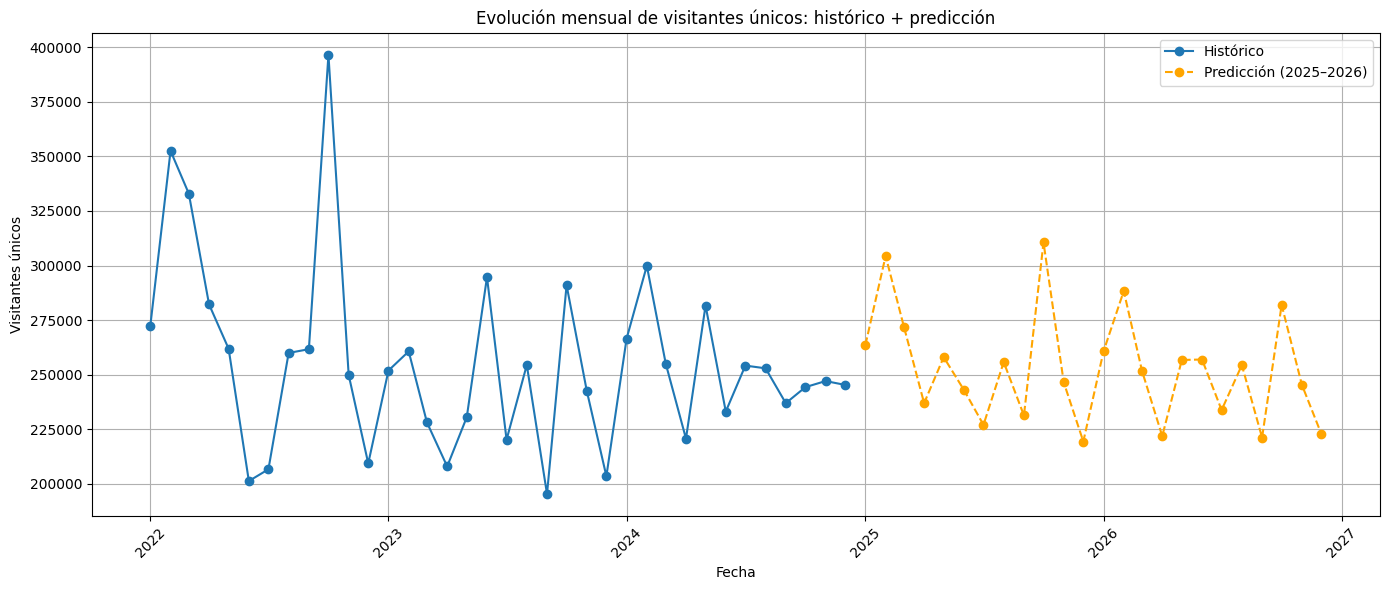

In [53]:
plt.figure(figsize=(14, 6))

# Histórico
plt.plot(df_web.index, df_web['Unique_visitors'], label='Histórico', marker='o')

# Predicción 2025-2026
plt.plot(df_pred_UV.index, df_pred_UV['Prediccion_Unique_visitors'], label='Predicción (2025–2026)', linestyle='--', marker='o', color='orange')

plt.title('Evolución mensual de visitantes únicos: histórico + predicción')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
# Cambiar nombre de la columna si hace falta
df_pred_UV.rename(columns={'Prediccion_Unique_visitors': 'Unique_visitors'}, inplace=True)
df_futuro = df_futuro.join(df_pred_UV[['Unique_visitors']], how='left')
df_futuro.head()


,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors
2025-01-01,31,1.0,23,8,0,263567.000000
2025-02-01,28,4.0,20,8,0,304353.333333
2025-03-01,31,4.0,21,10,0,271983.333333
2025-04-01,30,7.0,22,8,1,236862.000000
2025-05-01,31,2.0,22,9,0,257969.000000


In [55]:
predicciones_2025_DT = []
for mes in range(1, 13):
    datos_historicos = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2022, 2023, 2024]))
    ]['DirectTraffic']
    
    prediccion = datos_historicos.mean()
    predicciones_2025_DT.append(prediccion)

fechas_2025 = pd.date_range(start="2025-01-01", end="2025-12-01", freq="MS")
df_2025_DT = pd.DataFrame({'Fecha': fechas_2025, 'Prediccion_DirectTraffic': predicciones_2025_DT})


predicciones_2026_DT = []
for mes in range(1, 13):
    datos_2023_2024 = df_web[
        (df_web['month'] == mes) & 
        (df_web['year'].isin([2023, 2024]))
    ]['DirectTraffic']
    
    pred_2025 = df_2025_DT[df_2025_DT['Fecha'].dt.month == mes]['Prediccion_DirectTraffic'].values[0]
    
    datos_combinados = list(datos_2023_2024) + [pred_2025]
    prediccion = sum(datos_combinados) / len(datos_combinados)
    predicciones_2026_DT.append(prediccion)

fechas_2026 = pd.date_range(start="2026-01-01", end="2026-12-01", freq="MS")
df_2026_DT = pd.DataFrame({'Fecha': fechas_2026, 'Prediccion_DirectTraffic': predicciones_2026_DT})


df_pred_DT = pd.concat([df_2025_DT, df_2026_DT], ignore_index=True)
df_pred_DT.set_index('Fecha', inplace=True)

df_pred_DT.head()

,Prediccion_DirectTraffic
Fecha,
2025-01-01,86220.333333
2025-02-01,92794.666667
2025-03-01,82812.000000
2025-04-01,72764.666667
2025-05-01,72812.333333


**DirectTraffic**

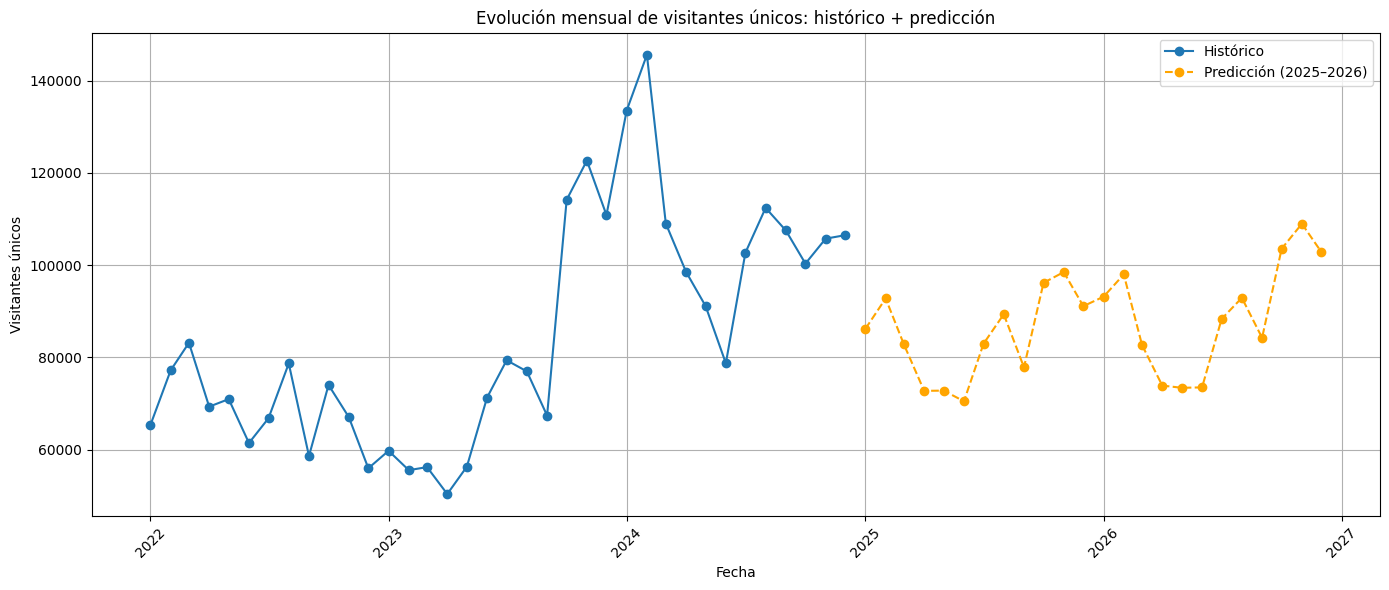

In [56]:
plt.figure(figsize=(14, 6))

# Histórico
plt.plot(df_web.index, df_web['DirectTraffic'], label='Histórico', marker='o')

# Predicción 2025-2026
plt.plot(df_pred_DT.index, df_pred_DT['Prediccion_DirectTraffic'], label='Predicción (2025–2026)', linestyle='--', marker='o', color='orange')

plt.title('Evolución mensual de visitantes únicos: histórico + predicción')
plt.xlabel('Fecha')
plt.ylabel('Visitantes únicos')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
df_pred_DT.rename(columns={'Prediccion_DirectTraffic': 'DirectTraffic'}, inplace=True)
df_futuro = df_futuro.join(df_pred_DT[['DirectTraffic']], how='left')
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333


## Variable Mercado

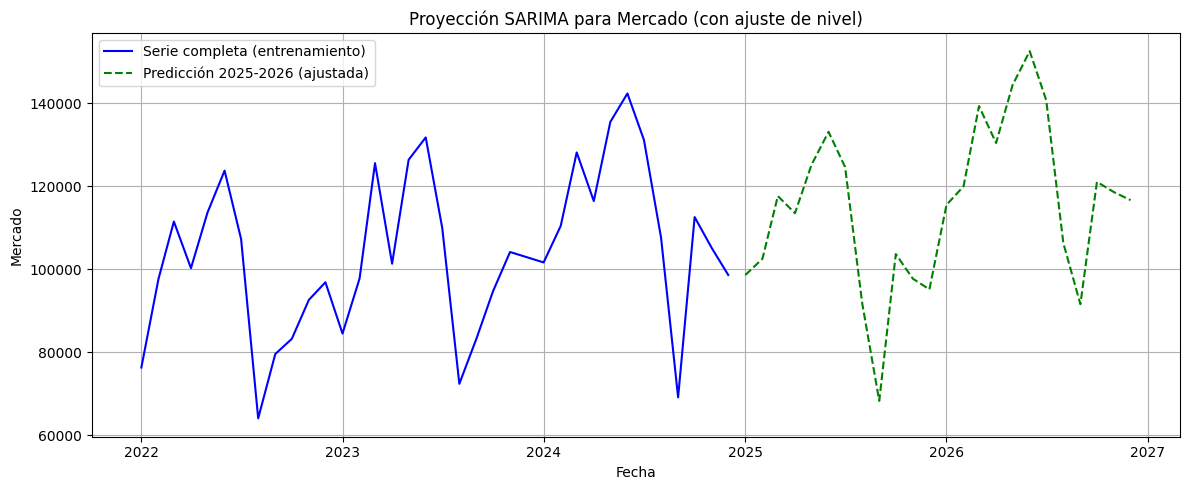

In [58]:
df_pred_mercado_sarima.head()

,Fecha,Mercado
0,2025-01-01,98634.000000
1,2025-02-01,102528.677793
2,2025-03-01,117652.495742
3,2025-04-01,113512.663871
4,2025-05-01,125159.943305


In [59]:
df_pred_mercado_sarima.set_index('Fecha', inplace=True)
df_pred_mercado_sarima.index = pd.to_datetime(df_pred_mercado_sarima.index)

In [60]:
df_futuro = df_futuro.join(df_pred_mercado_sarima, how='left')

In [61]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305


## Delays

**Unique_Visitors_1_ago**

In [62]:
df_futuro["Unique_visitors_1_ago"] = df_futuro["Unique_visitors"].shift(1)

In [63]:
ultimo_valor_2024 = df_web.loc['2024-12-01', 'Unique_visitors']

# El primer valor Nan -> cambiamos por ultimo valor dic de 2024
df_futuro.loc['2025-01-01', 'Unique_visitors_1_ago'] = ultimo_valor_2024

In [64]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000,245232.000000
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793,263567.000000
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742,304353.333333
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871,271983.333333
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305,236862.000000


**Visit_Store/Sales**

In [71]:
df_futuro.loc["2025-01-01", "Visit_Store_1_ago"] = df_off.loc["2024-12-01", "Visit_Store"]
df_futuro.loc["2025-01-01", "Sales_1_ago"] = df_off.loc["2024-12-01", "Sales"]

In [74]:
df_futuro.head()

,Dias_mes,Dia_inicio_mes,working_days,Dias_fines_semana,Easterweek,Unique_visitors,DirectTraffic,Mercado,Unique_visitors_1_ago,Visit_Store_1_ago,Sales_1_ago
2025-01-01,31,1.0,23,8,0,263567.000000,86220.333333,98634.000000,245232.000000,6618.0,1897.0
2025-02-01,28,4.0,20,8,0,304353.333333,92794.666667,102528.677793,263567.000000,NaN,NaN
2025-03-01,31,4.0,21,10,0,271983.333333,82812.000000,117652.495742,304353.333333,NaN,NaN
2025-04-01,30,7.0,22,8,1,236862.000000,72764.666667,113512.663871,271983.333333,NaN,NaN
2025-05-01,31,2.0,22,9,0,257969.000000,72812.333333,125159.943305,236862.000000,NaN,NaN
